# Exploratory Data Analysis

This notebook explores relationships between objective function paramameters, dose statistics, and clinical goals.
I randomly sampled 100 treatment plans by changing the DoseValue parameter for five OARs:
* SpinalCanal
* Heart
* Rib
* Chestwall_L
* Lungs

I recorded DoseValue parameters used, dose statistics, and clinical goal values for each plan and each ROI (including the PTV).
My main goal was to see if there are any clear correlations between the different ROIs.
I'm also interested in looking into how we can design a better kernel for the Gaussian processes used in our Bayesian optimization.

### Objective function terms

Objective function terms can be accessed with the following code:
```python
import connect
plan = connect.get_current('Plan')
funcs = plan.PlanOptimizations[0].Objective.ConstituentFunctions
```

Relevant values for the ``ii``th term can be found here:
```python
funcs[ii].ForRegionOfInterest.Name
funcs[ii].DoseFunctionParameters.FunctionType
funcs[ii].DoseFunctionParameters.DoseLevel
funcs[ii].DoseFunctionParameters.PercentVolume
funcs[ii].DoseFunctionParameters.Weight
```

The following are the parameters used for the approved plan:

idx | Name | Description | FunctionType | DoseValue | PercentVolume | Weight
-|-|-|-|-|-|-
0 | SpinalCanal | Max Dose 2080 cGy | MaxDose | 2080 | 95 | 90
2 | Heart | Max Dose 2800 cGy | MaxDose | 2800 | 95 | 90
6 | Rib | Max Dose 3200 cGy | MaxDose | 3200 | 95 | 90
8 | PTV | Max Dose 6240 cGy | MaxDose | 6240 | 0 | 95
9 | PTV | Min Dose 4800 cGy | MinDose | 4800 | 0 | 100
10 | Chestwall_L | Max DVH 3000 cGy to 1.5% volume | MaxDvh | 3000 | 1.5 | 90
11 | Lungs | Max DVH 2000 cGy to 10% volume | MaxDvh | 2000 | 10 | 90

### Dose Statistics

Dose statistics can be accessed with the following code:
```python
dose = plan.TreatmentCourse.TotalDose
dose.GetDoseStatistic(RoiName=roi, DoseType='Min')
dose.GetDoseStatistic(RoiName=roi, DoseType='Average')
dose.GetDoseStatistic(RoiName=roi, DoseType='Max')
dose.GetDoseAtRelativeVolumes(RoiName=roi, RelativeVolumes=[0.99, 0.98, ...])
dose.GetRelativeVolumeAtDose(RoiName=roi, DoseValues=np.linspace(0, max_dose, 100))
```

### Clinical goals

Clinical goals can be accessed with the following code:
```python
goals = plan.TreatmentCourse.EvaluationSetup.EvaluationFunctions
```

Relevant values for the ``ii``th term can be found here:
```python
goals[ii].ForRegionOfInterest.Name
goals[ii].PlanningGoal.Type
goals[ii].PlanningGoal.GoalCriteria
goals[ii].PlanningGoal.AcceptanceLevel
goals[ii].PlanningGoal.ParameterValue
goals[ii].GetClinicalGoalValue()
```

The following goals are used for the approved plan:

idx | Name | Description | Type | GoalCriteria | AcceptanceLevel | ParameterValue
-|-|-|-|-|-|-
2 | Heart | At most 3400 cGy dose at 0 cm$^3$ volume | DoseAtAbsoluteVolume | AtMost | 3400 | 0
3 | Heart | At most 15 cm$^3$ volume at 2800 cGy dose | AbsoluteVolumeAtDose | AtMost | 15 | 2800
8 | Lungs | At most 1500 cm$^3$ volume at 1160 cGy dose | AbsoluteVolumeAtDose| AtMost | 1500 | 1160
9 | Lungs | At most 10 % volume at 2000 cGy dose | VolumeAtDose | AtMost | 0.1 | 2000
11 | SpinalCanal |  At most 2080 cGy dose at 0.35 cm$^3$ volume | DoseAtAbsoluteVolume| AtMost | 2080 | 0.35
14 | Rib | At most 1 cm$^3$ volume at 3200 cGy dose | AbsoluteVolumeAtDose | AtMost | 1 | 3200
15 | Rib | At most 4000 cGy dose at 0.04 cm$^3$ volume | DoseAtAbsoluteVolume | AtMost | 4000 | 0.035
18 | Chestwall_L | At most 30 cm$^3$ volume at 3000 cGy dose | AbsoluteVolumeAtDose | AtMost | 30 | 3000
19 | PTV | At least 95 % volume at 4800 cGy dose | VolumeAtDose | AtLeast | 0.95 | 4800
20 | PTV | At least 99 % volume at 4320 cGy dose | VolumeAtDose | AtLeast | 0.99 | 4320

### Results Format

My script samples.py saves results as a list, where each list element corresponds to one sampled treatment plan. Each treatment plan contains the following three dictionaries:

Dose Parameters
```python
{ Name : [{'idx', 'DoseLevel', 'Range'}] }
```

Dose Statistics
```python
{ Name : {'Min', 'Max', 'Average', 'D99', 'D98', 'D95', 'D50', 'D5', 'D2','D1'} }
```

Clinical Goals
```python
{ Name : [{ 'idx', 'GoalCriteria', 'AcceptanceLevel', 'GoalValue' }] }
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
import utils

# Dose parameters

In [2]:
# Organize based on flag
samples_full = np.load('samples_6_8.npy', allow_pickle=True)
samples = []
samples_norm = []
samples_opt = []
for sample in samples_full:
    if len(sample) == 3:
        samples.append(sample)
    elif len(sample) == 2:
        samples_norm.append(sample)
    else:
        samples_opt.append(sample)
print(f'{len(samples)}/100 Succeeded, '\
      f'{len(samples_norm)}/100 Normalization Failed, '\
      f'{len(samples_opt)}/100 Optimization Failed')

# Since optimization never failed, only normalization, I can add
# a flag and an estimated normalized value to the results next time.

68/100 Succeeded, 32/100 Normalization Failed, 0/100 Optimization Failed


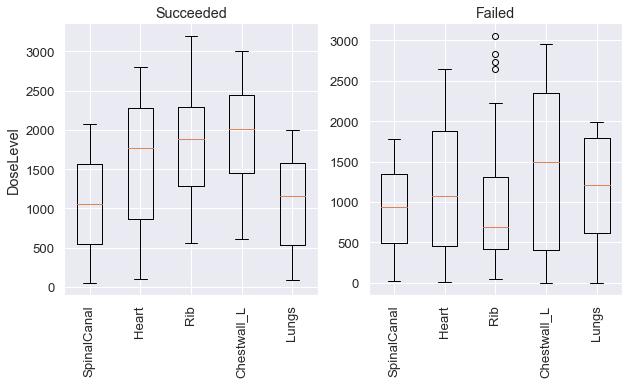

In [3]:
# When did plans work or not work?
oar_list = ['SpinalCanal', 'Heart', 'Rib', 'Chestwall_L', 'Lungs']
data = [[], []]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for oar in oar_list: 
    data[0].append(np.array(utils.roi_pars(samples, oar)[0]))
    data[1].append(np.array(utils.roi_pars(samples_norm, oar)[0]))
ax[0].boxplot(data[0])
ax[1].boxplot(data[1])
ax[0].set_xticklabels(oar_list, rotation=90)
ax[1].set_xticklabels(oar_list, rotation=90)
ax[0].set_ylabel('DoseLevel')
ax[0].set_title('Succeeded')
ax[1].set_title('Failed');

# The plans that succeeded all have Rib and Chestwall_L paramters
# above a certain range, which suggests these paramter values have
# a minimum feasible value. 

# Dose Statistics

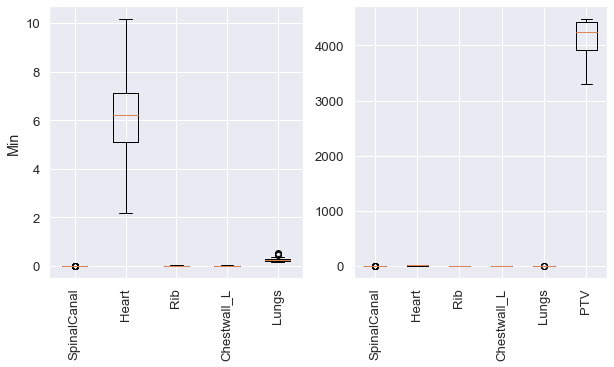

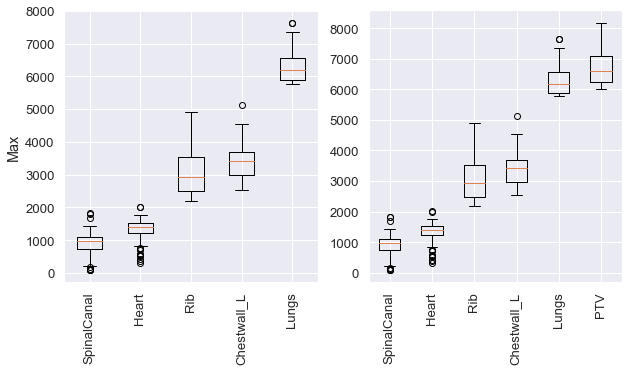

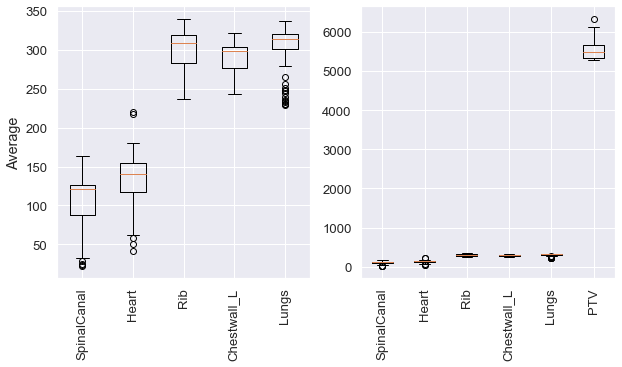

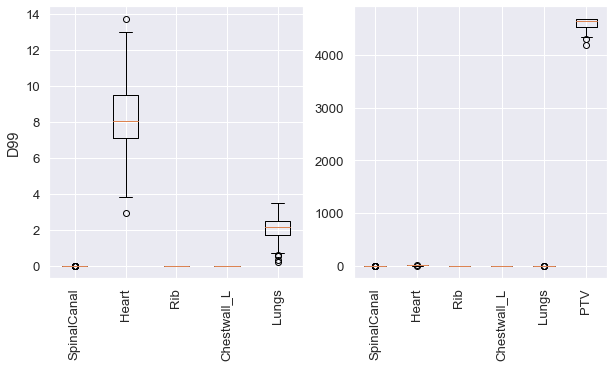

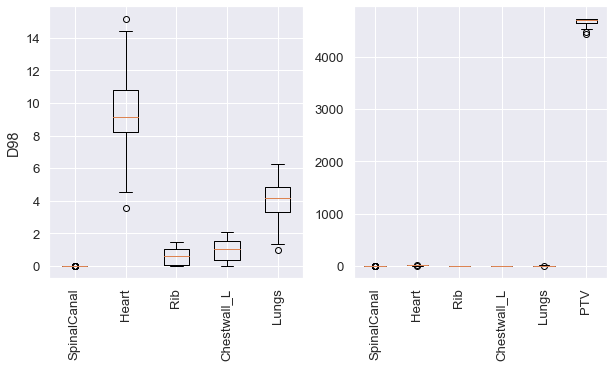

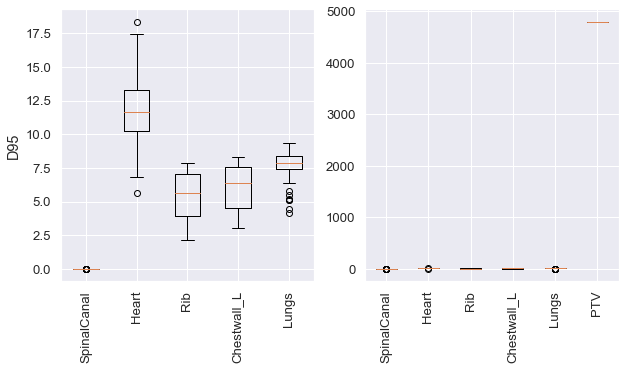

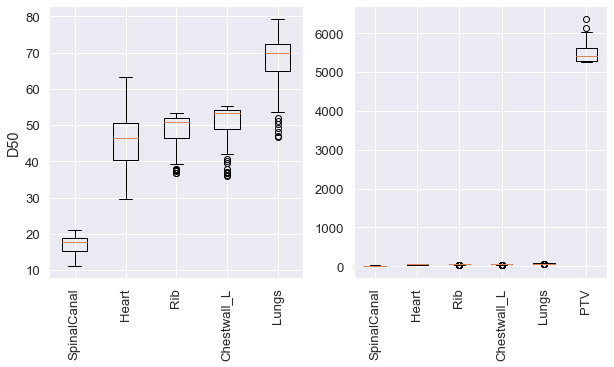

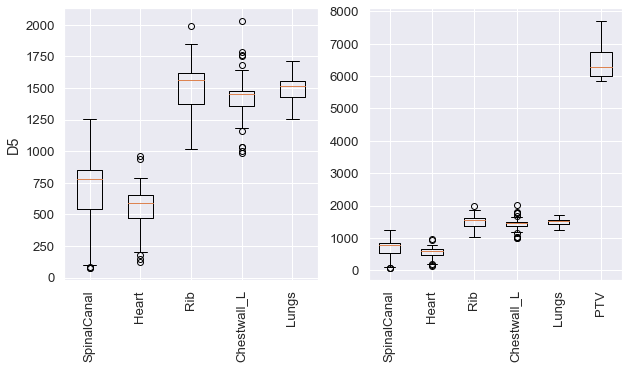

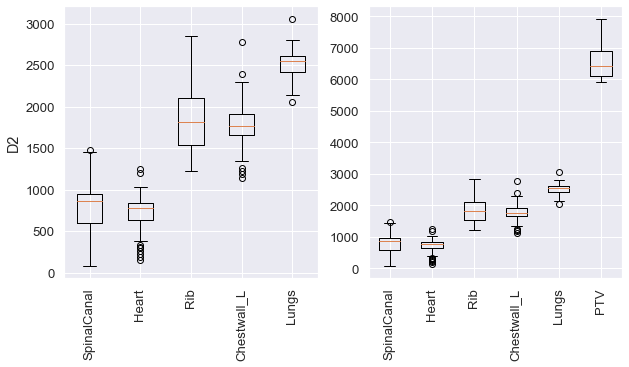

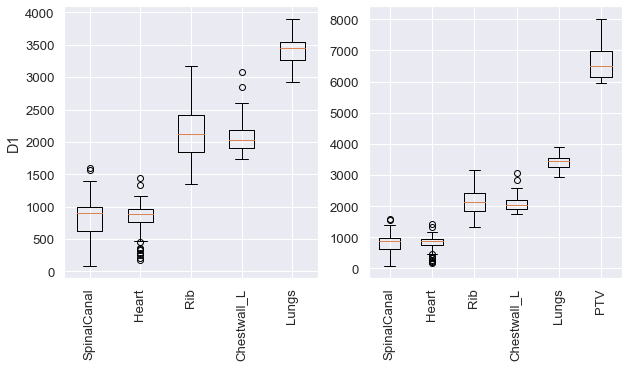

In [4]:
# Plot each statistics for all ROIs
roi_list = ['SpinalCanal', 'Heart', 'Rib', 'Chestwall_L', 'Lungs', 'PTV']
for stat in samples[0][1]['Heart'].keys():
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    data = []
    for oar in oar_list:
        data.append(np.array(utils.roi_stats(samples, oar, stat)))
    for ii in range(2):
        if ii == 1:
            data.append(np.array(utils.roi_stats(samples, 'PTV', stat)))
        ax[ii].boxplot(data)
        if ii == 0:
            ax[ii].set_xticklabels(labels=oar_list, rotation=90)
            ax[ii].set_ylabel(stat)
        else:
            ax[ii].set_xticklabels(labels=roi_list, rotation=90)

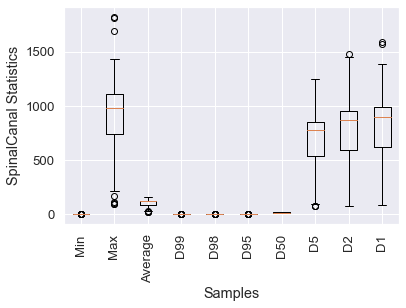

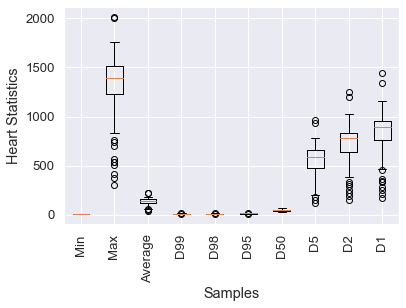

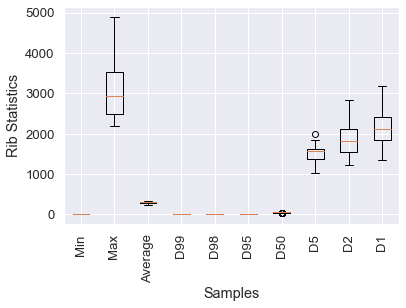

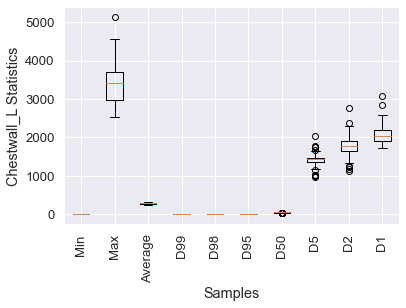

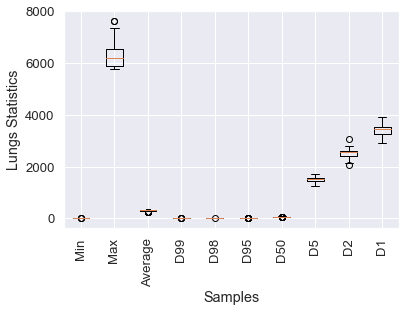

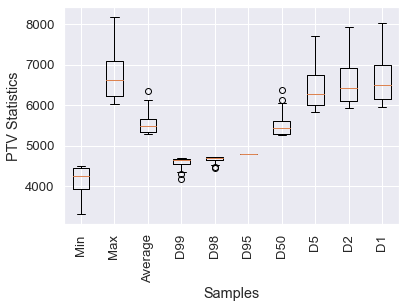

In [5]:
# Plot all statistics for each ROI
for roi in roi_list:
    plt.figure()
    data = []
    for stat in samples[0][1][roi].keys():
        data.append(utils.roi_stats(samples, roi, stat))
    plt.boxplot(data)
    plt.xlabel('Samples')
    plt.ylabel(f'{roi} Statistics')
    plt.xticks(ticks=np.arange(len(samples[0][1][roi])) + 1, labels=samples[0][1][roi].keys(), rotation=90)

# Clinical Goals

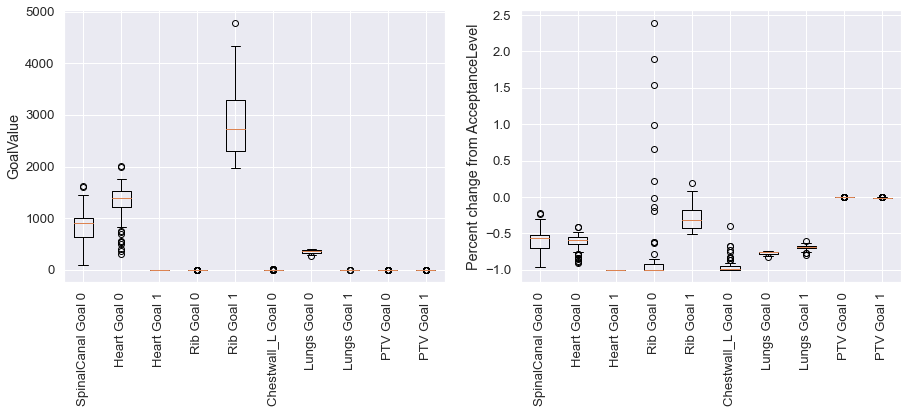

In [6]:
# Plot percent difference from clinical goal
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for ii in range(2):
    data = []
    labels = []
    for roi in roi_list:
        goals = utils.roi_goals(samples, roi, percent=ii)
        for jj in range(len(goals)):
            data.append(goals[jj])
            labels.append(f'{roi} Goal {jj}')
    ax[ii].boxplot(data)
    ax[ii].set_xticklabels(labels=labels, rotation=90)
    if ii == 0:
        ax[ii].set_ylabel('GoalValue')
    else:
        ax[ii].set_ylabel('Percent change from AcceptanceLevel')

# Since the PTV doesn't have a goal based on the maximum value, 
# scoring plans based only on clinical goals will not be able to 
# limit the maximum dose!

# Covariance and Correlation within Statistics

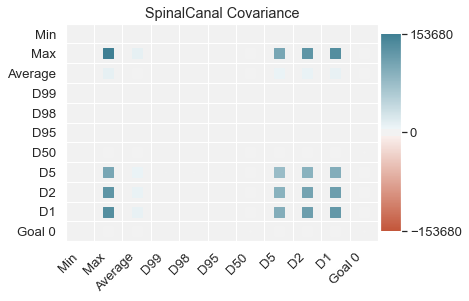

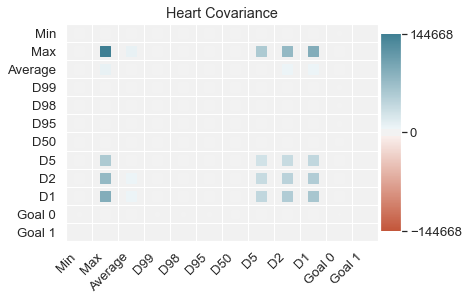

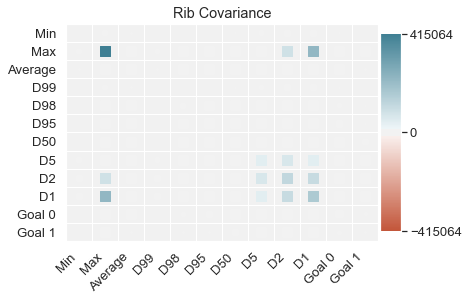

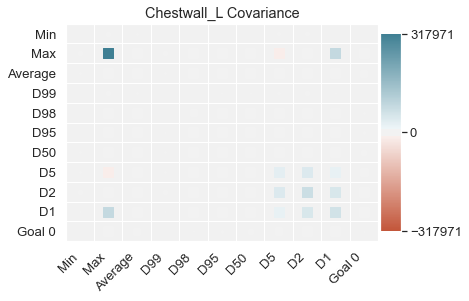

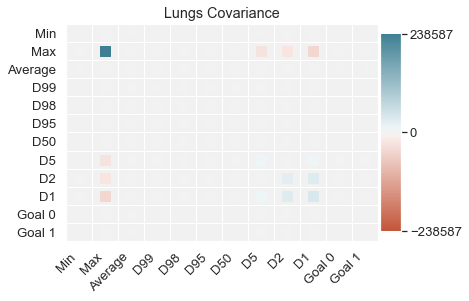

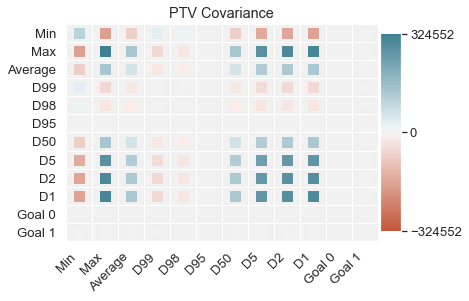

In [7]:
# Plot covariances
for roi in roi_list:
    roi_dict = {}
    for stat in samples[0][1][roi].keys():
        roi_dict[stat] = utils.roi_stats(samples, roi, stat)
    goal_list = utils.roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        roi_dict[f'Goal {ii}'] = goal_list[ii]
    roi_df = pd.DataFrame(data=roi_dict) 
    plt.figure()
    utils.covplot(data=roi_df.cov(), title=f'{roi} Covariance')

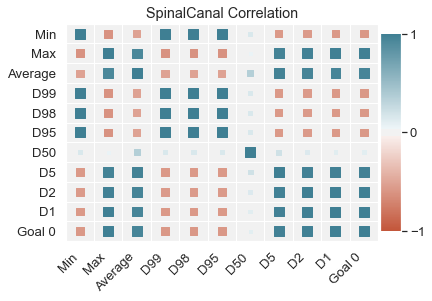

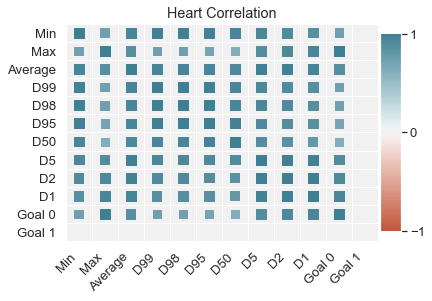

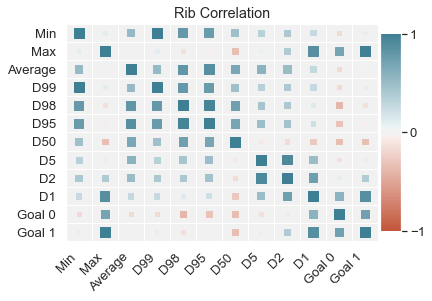

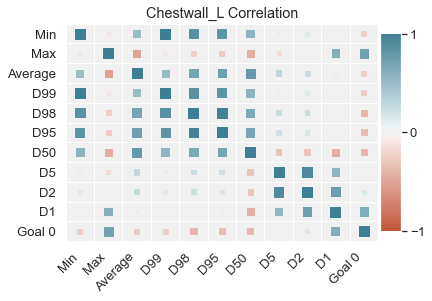

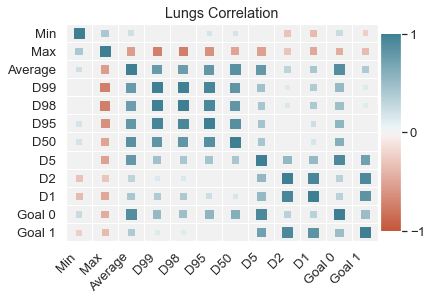

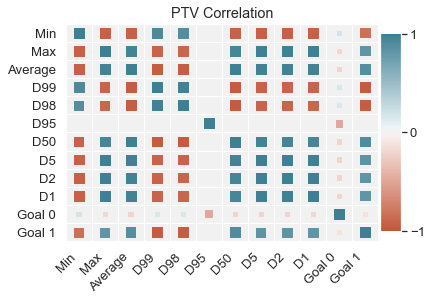

In [8]:
# Plot correlations
for roi in roi_list:
    roi_dict = {}
    for stat in samples[0][1][roi].keys():
        roi_dict[stat] = utils.roi_stats(samples, roi, stat)
    goal_list = utils.roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        roi_dict[f'Goal {ii}'] = goal_list[ii]
    roi_df = pd.DataFrame(data=roi_dict) 
    plt.figure()
    utils.corrplot(data=roi_df.corr(), title=f'{roi} Correlation')
    
# Note: Heart Goal 1 always had value -1, so no variance, so correlation was NaN

# Covariance and Correlation within ROIs

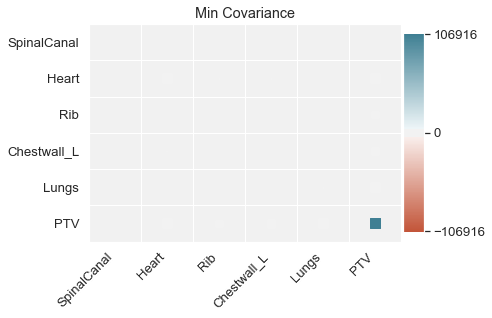

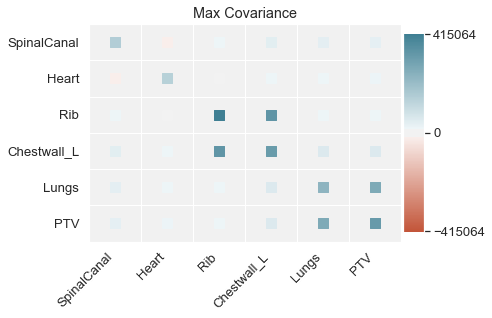

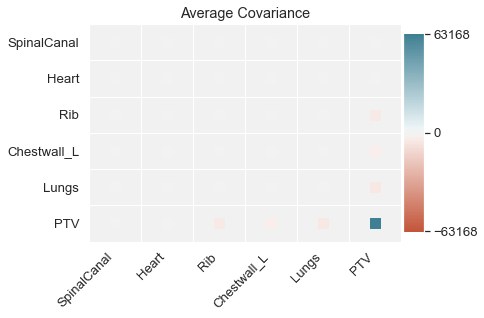

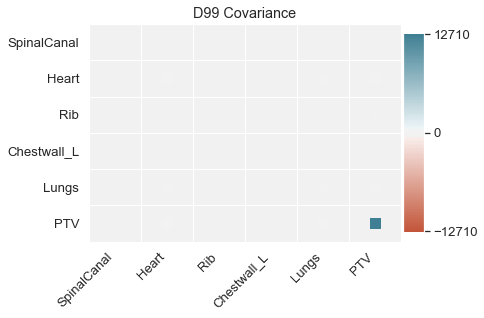

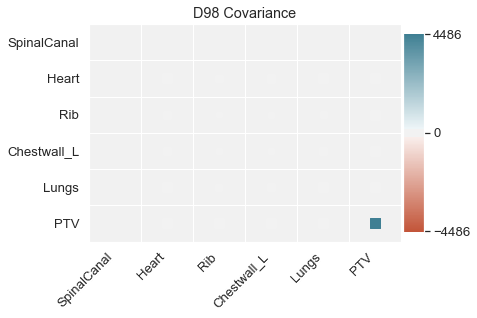

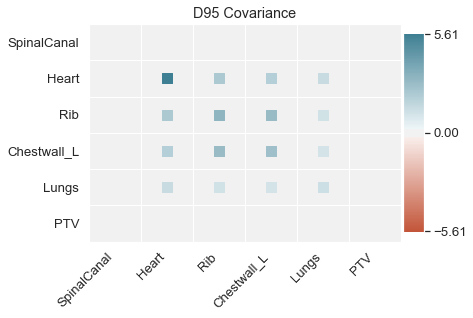

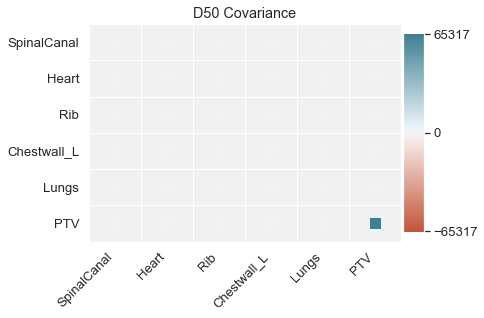

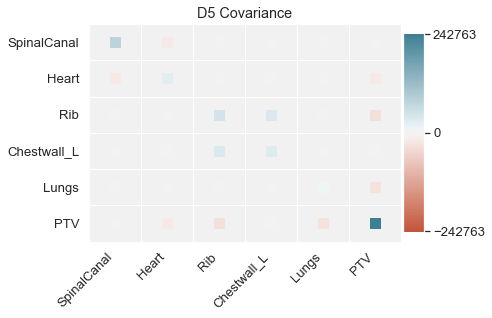

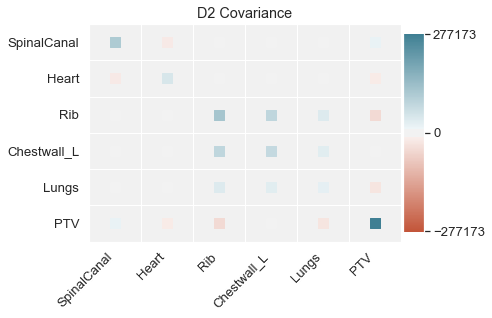

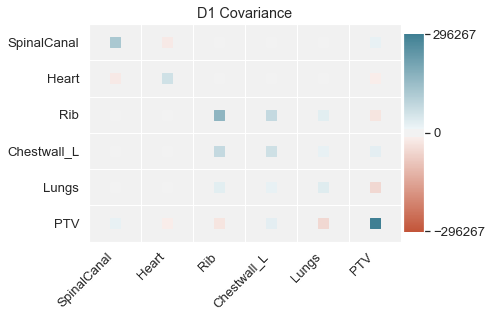

In [9]:
# Plot covariances
for stat in samples[0][1]['Heart'].keys():
    stat_dict = {}
    for roi in roi_list:
        stat_dict[roi] = utils.roi_stats(samples, roi, stat)
    stat_df = pd.DataFrame(data=stat_dict)
    plt.figure()
    utils.covplot(data=stat_df.cov(), title=f'{stat} Covariance')

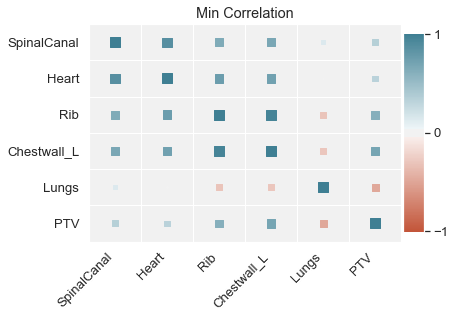

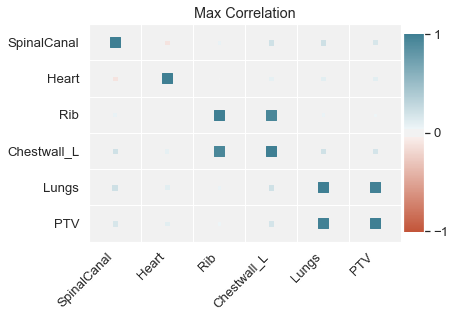

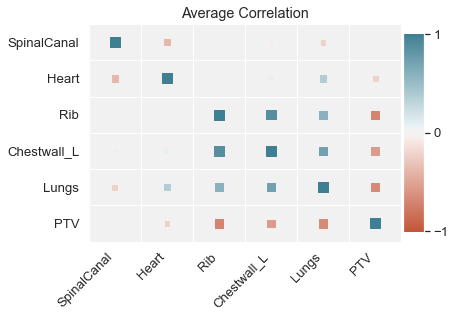

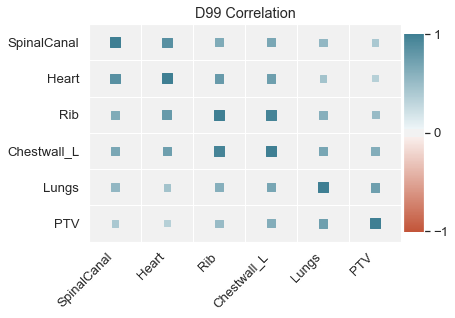

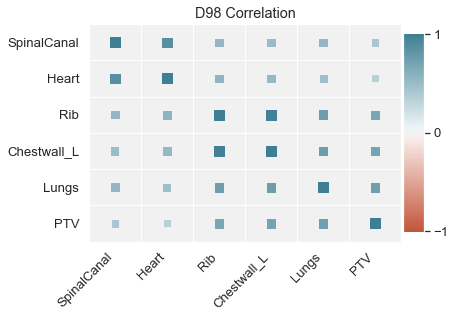

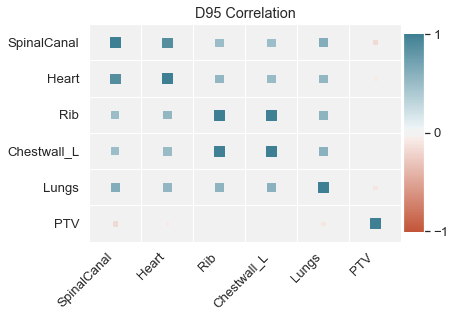

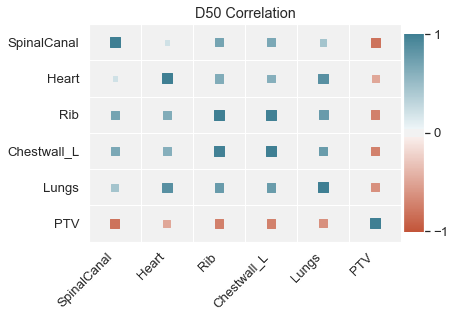

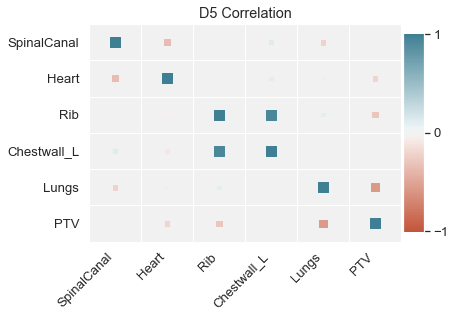

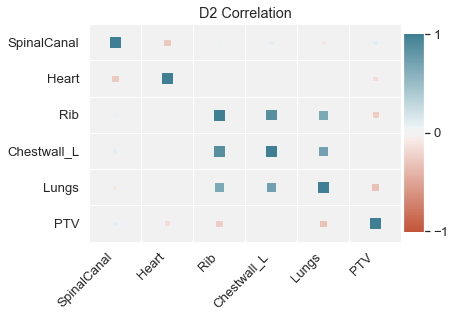

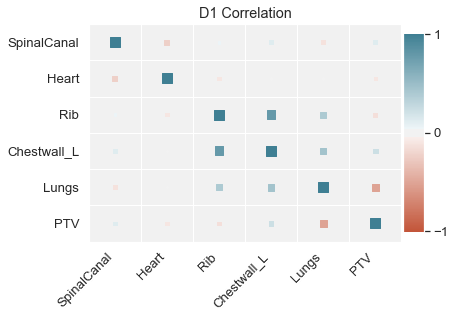

In [10]:
# Plot correlations
for stat in samples[0][1]['Heart'].keys():
    stat_dict = {}
    for roi in roi_list:
        stat_dict[roi] = utils.roi_stats(samples, roi, stat)
    stat_df = pd.DataFrame(data=stat_dict)
    plt.figure()
    utils.corrplot(data=stat_df.corr(), title=f'{stat} Correlation')

# Covariance and Correlation with Goals

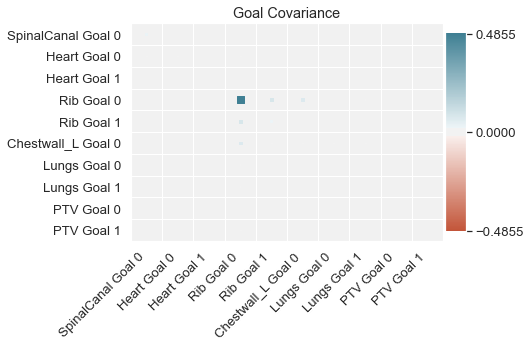

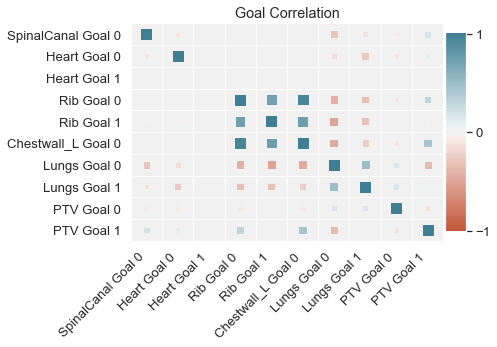

In [11]:
goal_dict = {}
for roi in roi_list:
    goal_list = utils.roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        goal_dict[f'{roi} Goal {ii}'] = goal_list[ii]
    goal_df = pd.DataFrame(data=goal_dict)
    
# Plot covariance
plt.figure()
utils.covplot(data=goal_df.cov(), title='Goal Covariance')

# Plot correlations
plt.figure()
utils.corrplot(data=goal_df.corr(), title='Goal Correlation')

# Covariance between Parameters and Statistics

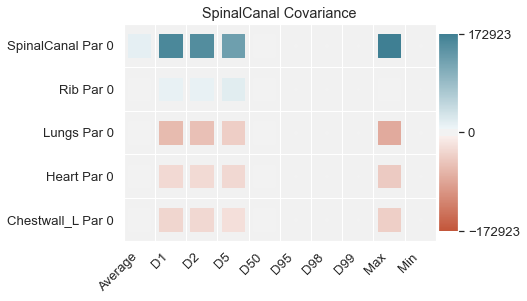

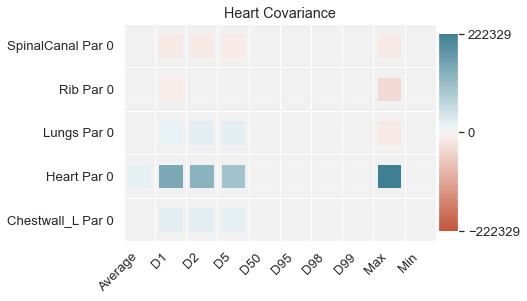

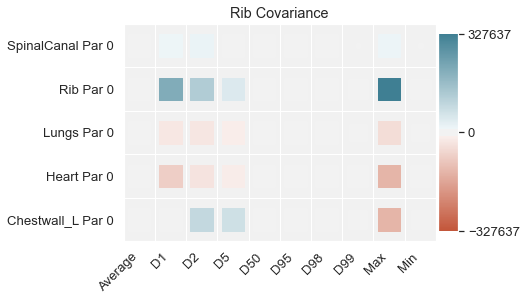

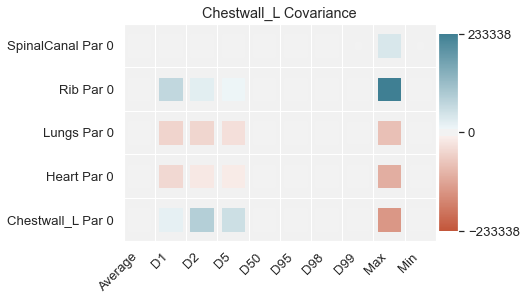

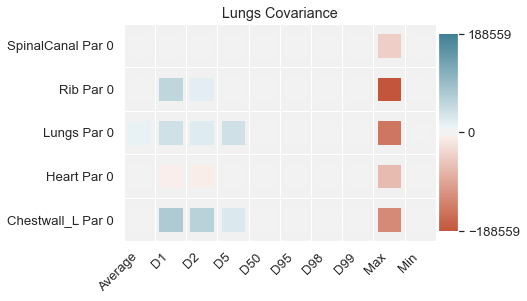

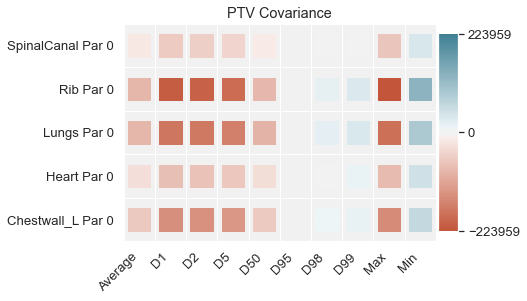

In [12]:
for roi in roi_list:
    # Add dose parameters
    res_dict = {}
    par_labels = []
    for oar in oar_list:
        par_list = utils.roi_pars(samples, oar)
        for ii in range(len(par_list)):
            label = f'{oar} Par {ii}'
            par_labels.append(label)
            res_dict[label] = par_list[ii]
            
    # Add dose statistics
    stat_labels = []
    for stat in samples[0][1][roi].keys():
        stat_labels.append(stat)
        res_dict[stat] = utils.roi_stats(samples, roi, stat)
    
    # Create DataFrame
    res_df = pd.DataFrame(data=res_dict)
    res_cov = res_df.cov()
    res_cov = res_cov[par_labels].loc[stat_labels]

    # Plot covariance
    plt.figure()
    cov = pd.melt(res_cov.reset_index(), id_vars='index').replace(np.nan, 0)
    cov.columns = ['x', 'y', 'value']
    max_val = max(abs((cov['value'])))
    utils.heatmap(
        cov['x'], cov['y'], 
        color=cov['value'], color_range=[-max_val, max_val],
        palette=sns.diverging_palette(20, 220, n=256),
        size=cov['value'].abs(), size_range=[0, 1],
        title=f'{roi} Covariance'
    )

# Correlation between Parameters and Statistics

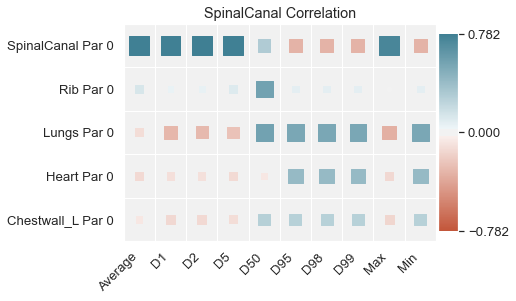

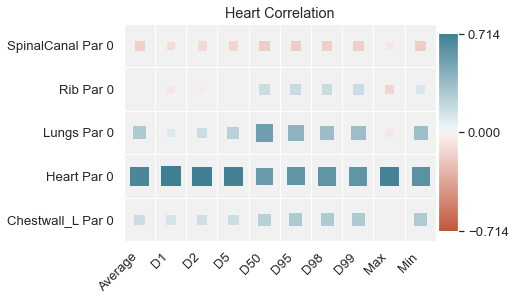

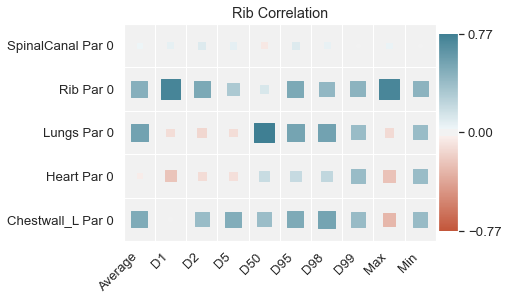

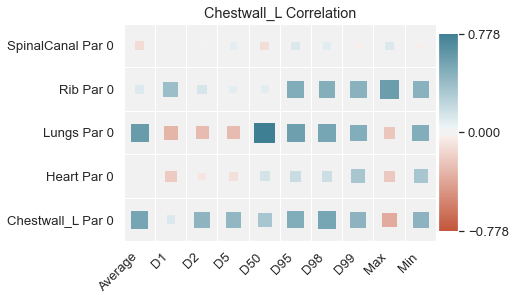

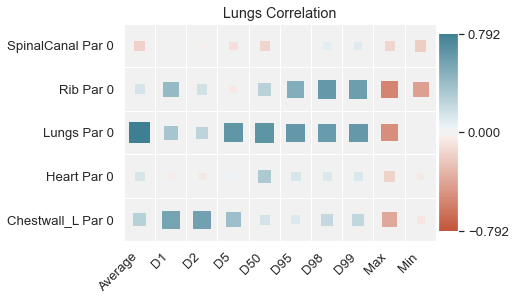

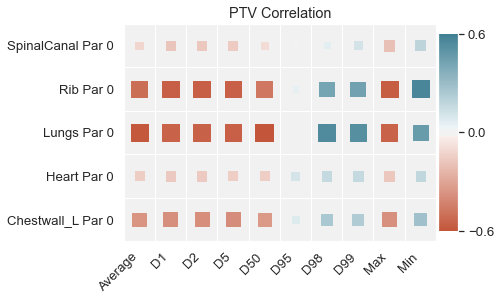

In [13]:
for roi in roi_list:
    # Add dose parameters
    res_dict = {}
    par_labels = []
    for oar in oar_list:
        par_list = utils.roi_pars(samples, oar)
        for ii in range(len(par_list)):
            label = f'{oar} Par {ii}'
            par_labels.append(label)
            res_dict[label] = par_list[ii]
            
    # Add dose statistics
    stat_labels = []
    for stat in samples[0][1][roi].keys():
        stat_labels.append(stat)
        res_dict[stat] = utils.roi_stats(samples, roi, stat)
    
    # Create DataFrame
    res_df = pd.DataFrame(data=res_dict)
    res_corr = res_df.corr()
    res_corr = res_corr[par_labels].loc[stat_labels]

    # Plot covariance
    plt.figure()
    corr = pd.melt(res_corr.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    max_val = max(abs((corr['value'])))
    utils.heatmap(
        corr['x'], corr['y'], 
        color=corr['value'], color_range=[-max_val, max_val],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0, 1],
        title=f'{roi} Correlation'
    )

# Covariance and Correlation between Parameters and Goals

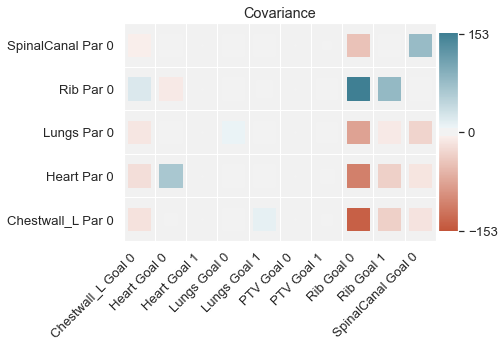

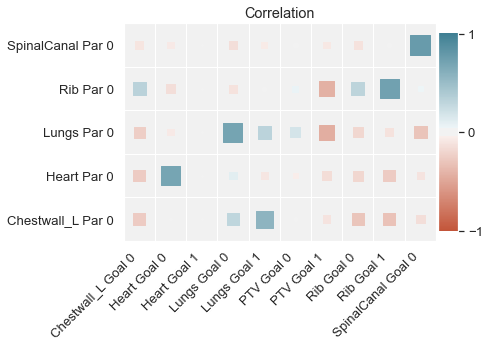

In [14]:
# Add dose parameters
res_dict = {}
par_labels = []
for oar in oar_list:
    par_list = utils.roi_pars(samples, oar)
    for ii in range(len(par_list)):
        label = f'{oar} Par {ii}'
        par_labels.append(label)
        res_dict[label] = par_list[ii]

# Add goal values
goal_labels = []
for roi in roi_list:
    goal_list = utils.roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        label = f'{roi} Goal {ii}'
        goal_labels.append(label)
        res_dict[label] = goal_list[ii]

# Create DataFrame
res_df = pd.DataFrame(data=res_dict)
res_cov = res_df.cov()
res_cov = res_cov[par_labels].loc[goal_labels]
res_corr = res_df.corr()
res_corr = res_corr[par_labels].loc[goal_labels]

# Plot covariance
plt.figure()
cov = pd.melt(res_cov.reset_index(), id_vars='index').replace(np.nan, 0)
cov.columns = ['x', 'y', 'value']
max_val = max(abs((cov['value'])))
utils.heatmap(
    cov['x'], cov['y'], 
    color=cov['value'], color_range=[-max_val, max_val],
    palette=sns.diverging_palette(20, 220, n=256),
    size=cov['value'].abs(), size_range=[0, 1],
    title='Covariance'
)

# Plot correlation
plt.figure()
corr = pd.melt(res_corr.reset_index(), id_vars='index').replace(np.nan, 0)
corr.columns = ['x', 'y', 'value']
utils.heatmap(
    corr['x'], corr['y'], 
    color=corr['value'], color_range=[-1, 1],
    palette=sns.diverging_palette(20, 220, n=256),
    size=corr['value'].abs(), size_range=[0, 1],
    title='Correlation'
)

In [15]:
# Reused code needs to be put into utils.py, reorganized...

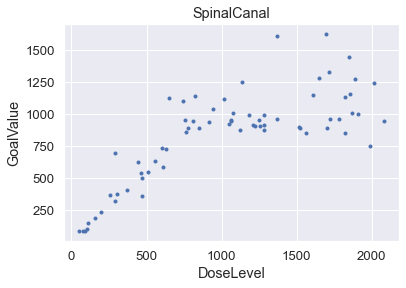

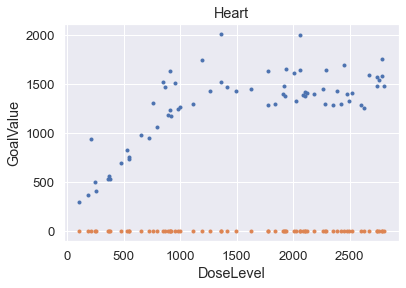

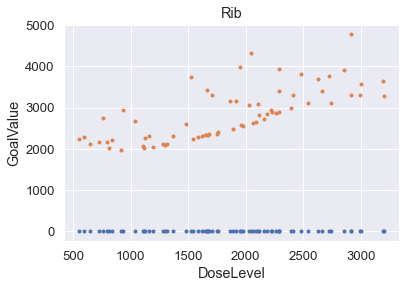

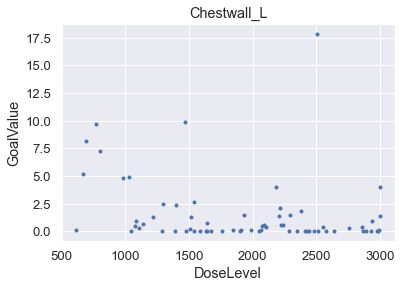

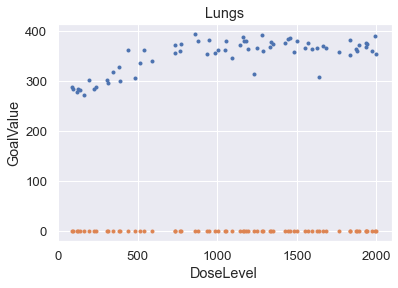

In [16]:
# Why does it appear that some parameters aren't positively correlated with their goals?

for oar in oar_list:
    plt.figure()
    par_list = utils.roi_pars(samples, oar)
    goal_list = utils.roi_goals(samples, oar, percent=False)
    for goal in goal_list:
        plt.plot(par_list[0], goal, '.')
    plt.xlabel('DoseLevel')
    plt.ylabel('GoalValue')
    plt.title(oar)
    
# Some appear to have a piecewise-linear relationship
# Specifically, a lower range where the objective term affects the solution,
# and an upper range where the term doesn't affect the solution.

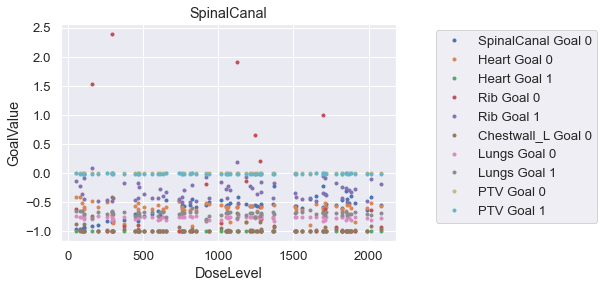

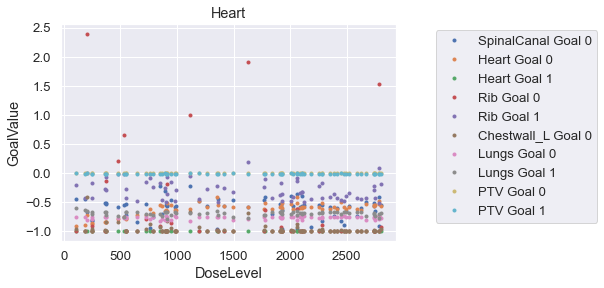

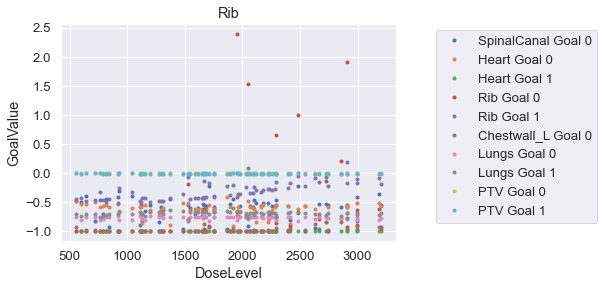

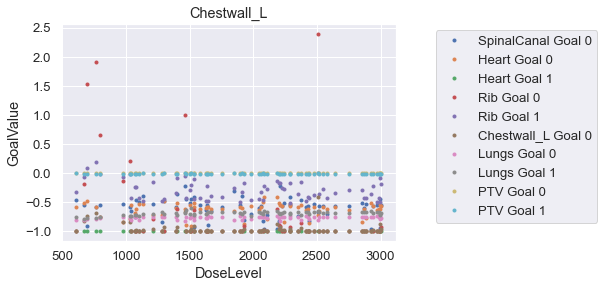

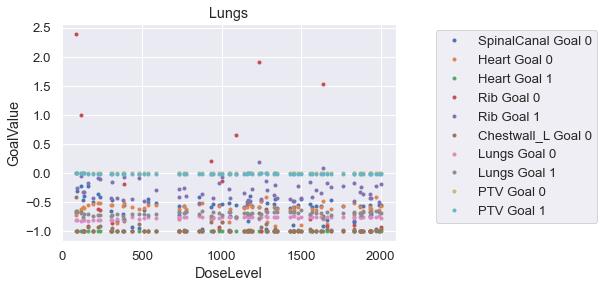

In [17]:
# Look at all parameters and goals

labels = []
for oar in oar_list:
    plt.figure()
    par_list = utils.roi_pars(samples, oar)
    for roi in roi_list:
        goal_list = utils.roi_goals(samples, roi)
        for ii in range(len(goal_list)):
            labels.append(f'{roi} Goal {ii}')
            plt.plot(par_list[0], goal_list[ii], '.')
    plt.xlabel('DoseLevel')
    plt.ylabel('GoalValue')
    plt.title(oar)
    plt.legend(labels=labels, bbox_to_anchor=(1.1, 1))
    
# Maybe this the treatment goals are easy enough for this patient that
# we don't really see strong relationships?

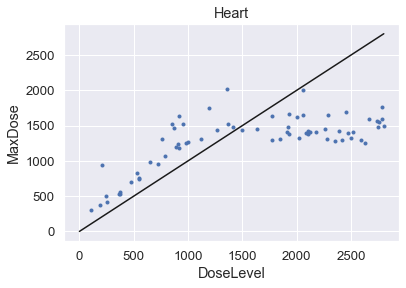

In [18]:
# Looking at objective values

roi = 'Heart'
pars = utils.roi_pars(samples, roi)
goals = utils.roi_stats(samples, roi, 'Max')
plt.plot(pars[0], goals, '.')
plt.plot([0, 2800], [0, 2800], 'k')
plt.xlabel('DoseLevel')
plt.ylabel('MaxDose')
plt.title(roi);

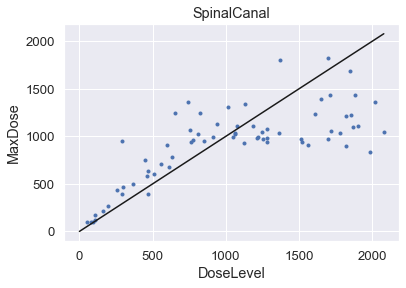

In [19]:
roi = 'SpinalCanal'
pars = utils.roi_pars(samples, roi)
goals = utils.roi_stats(samples, roi, 'Max')
plt.plot(pars[0], goals, '.')
plt.plot([0, 2080], [0, 2080], 'k')
plt.xlabel('DoseLevel')
plt.ylabel('MaxDose')
plt.title(roi);

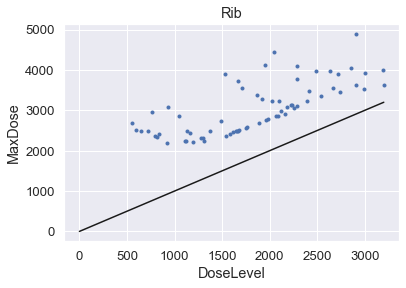

In [20]:
roi = 'Rib'
pars = utils.roi_pars(samples, roi)
goals = utils.roi_stats(samples, roi, 'Max')
plt.plot(pars[0], goals, '.')
plt.plot([0, 3200], [0, 3200], 'k')
plt.xlabel('DoseLevel')
plt.ylabel('MaxDose')
plt.title(roi);

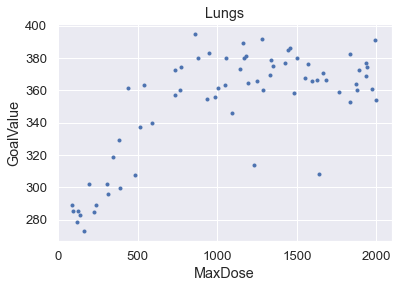

In [21]:
roi = 'Lungs'
pars = utils.roi_pars(samples, roi)
goals = utils.roi_goals(samples, roi, percent=False)
plt.plot(pars[0], goals[0], '.')
plt.xlabel('MaxDose')
plt.ylabel('GoalValue')
plt.title(roi);

# Wasn't recording D10, so not exactly the plot I wanted
# Volume at 1160 cGy dose

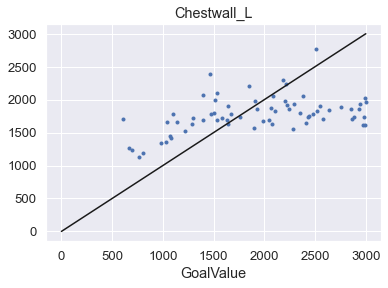

In [22]:
roi = 'Chestwall_L'
pars = utils.roi_pars(samples, roi)
goals = utils.roi_stats(samples, roi, 'D2')
plt.plot(pars[0], goals, '.')
plt.plot([0, 3000], [0, 3000], 'k')
plt.xlabel('GoalValue')
plt.ylabel('')
plt.title(roi);

# Should be D1.5, but didn't record that either

# Looks like chestwall and rib parameters are what makes normalization fail?

In [26]:
# Why doesn't the treatment planner use the goals as the objectives?
# * Answer: They use trial-and-error to figure out which objectives to use.

# I'm sure some goals are correlated with different optimization functions,
# but wouldn't they be most strongly correlated with their actual optimization function?
# * If we are tuning the parameters anyway, maybe not important?

# What sort of approach to treatment planners use?
# * If we could record their steps, what combination of exploration vs. exploitation
#   would they use?